In [16]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import constants as const
from astropy import units as u
import scipy.signal

c = const.c
G = const.G
AU = (1*u.au).to('m')
M_sun = const.M_sun
M_earth = const.M_earth

### Basic utility functions

In [17]:
def rel_len(x_1, x_2):
    r_vec = x_1 - x_2
    r = np.linalg.norm(r_vec)
    return r

def findrCM(x_1, x_2, m_1, m_2):
    M = m_1 + m_2
    r_cm = (m_1*x_1 + m_2*x_2)/M
    return r_cm

def γ(v):
    return 1/np.sqrt(1 - np.dot(v,v))

### Acceleration equation and integration functions

In [18]:
def accelerationN(r_vec, v_vec, p_vec, m_1, m_2):
    
    r = np.linalg.norm(r_vec)

    a = -(m_1 + m_2)*r_vec/r**3
    return a

def accelerationEIH(r_vec, v_vec, p_vec, m_1, m_2):
    r = np.linalg.norm(r_vec)
    v = np.linalg.norm(v_vec)
    
    r_dot = np.dot(r_vec, v_vec)/r

    # WHAT ABOUT γ?!!?!?!
    p = np.linalg.norm(p_vec)

    p_vec_dot = m_1*m_2*(m_1+m_2)/r**4*r_vec - 1/r**3*( (m_1*m_2 + (1/2 + 3/2*(m_1 + m_2)**2/(m_1*m_2))*p**2 + 3/2*np.dot(p_vec, r_vec)**2/r**2)*r_vec - np.dot(p_vec, r_vec)*p_vec )
    a = (1/m_1 + 1/m_2)*p_vec_dot - 3/2*(1/m_1**3 + 1/m_2**3)*p**2*p_vec_dot - 1/r*( -r_dot/r*((m_1*m_2 + 3*(m_1 + m_2)**2/(m_1*m_2))*p_vec + np.dot(p_vec, r_vec)/r**2*r_vec ) + (m_1*m_2 + 3*(m_1 + m_2)**2/(m_1*m_2))*p_vec_dot + ( (np.dot(p_vec_dot, r_vec) + np.dot(p_vec, v_vec))*r_vec + np.dot(p_vec, r_vec)*v_vec  )/r**2 - 2*np.dot(p_vec, r_vec)/r**3*r_vec*r_dot )
    return a


def acceleration1PM(r_vec, v_vec, p_vec, m_1, m_2):
    r = np.linalg.norm(r_vec)
    v = np.linalg.norm(v_vec)
    p = np.linalg.norm(p_vec)
    
    r_dot = np.dot(r_vec, v_vec)/r


    E_1 = np.sqrt(m_1**2 + p**2)
    E_2 = np.sqrt(m_2**2 + p**2)
    c_1 = (m_1*m_2)**2 - 2*(E_1*E_2 + p**2)**2

    p_vec_dot = 1*c_1/(E_1*E_2*r**3)*r_vec

    dE_1dp = p_vec/E_1
    dE_2dp = p_vec/E_2
    E_1_dot = np.dot(dE_1dp, p_vec_dot)
    E_2_dot = np.dot(dE_2dp, p_vec_dot)
    dE_1dp_dot = p_vec_dot/E_1 - p_vec/E_1**2*E_1_dot
    dE_2dp_dot = p_vec_dot/E_2 - p_vec/E_2**2*E_2_dot

    dc_1dp = -4*(E_1*E_2 + p**2)*((dE_1dp*E_2 + E_1*dE_2dp) + 2*p_vec)
    c_1_dot = -4*(E_1*E_2 + p**2)*((E_1_dot*E_2 + E_1*E_2_dot) + 2*np.dot(p_vec, p_vec_dot))
    dc_1dp_dot = -4*( ((E_1_dot*E_2 + E_1*E_2_dot) + 2*np.dot(p_vec, p_vec_dot))*((dE_1dp*E_2 + E_1*dE_2dp) + 2*p_vec) + (E_1*E_2 + p**2)*((dE_1dp_dot*E_2 + dE_1dp*E_2_dot + E_1_dot*dE_2dp + E_1*dE_2dp_dot) + 2*p_vec_dot) )

    a = dE_1dp_dot + dE_2dp_dot + 1/(E_1**2*E_2**2*r)*(  -( r_dot/r + 2*E_1_dot/E_1 + 2*E_2_dot/E_2 )*( E_1*E_2*dc_1dp - c_1*(dE_1dp*E_2 + E_1*dE_2dp) ) + (E_1_dot*E_2 + E_1*E_2_dot)*dc_1dp + E_1*E_2*dc_1dp_dot - c_1_dot*(dE_1dp*E_2 + E_1*dE_2dp) - c_1*(dE_1dp_dot*E_2 + dE_1dp*E_2_dot + E_1_dot*dE_2dp + E_1*dE_2dp_dot) )

    return a

def acceleration2PM(r_vec, v_vec, p_vec, m_1, m_2):
    r = np.linalg.norm(r_vec)
    v = np.linalg.norm(v_vec)
    p = np.linalg.norm(p_vec)
    
    r_dot = np.dot(r_vec, v_vec)/r


    E_1 = np.sqrt(m_1**2 + p**2)
    E_2 = np.sqrt(m_2**2 + p**2)
    c_1 = (m_1*m_2)**2 - 2*(E_1*E_2 + p**2)**2
    c_r = 3*m_1**2*((m_1*m_2)**2 - 5*(E_1*E_2 + p**2)**2)
    c_l = (m_2/m_1)**2*c_r

    p_vec_dot = c_1/(E_1*E_2*r**3)*r_vec + 1/r**4*2/(E_1*E_2)*r_vec*( 1/4*(c_r/m_1 + c_l/m_2) + c_1*(E_1 + E_2)/(E_1*E_2) * (c_1/2*(1/(E_1 + E_2)**2 - 1/(E_1*E_2)) - 4*(E_1*E_2 + p**2))  )
    p_dot = np.linalg.norm(p_vec_dot)

    dE_1dp = p_vec/E_1
    dE_2dp = p_vec/E_2
    E_1_dot = np.dot(dE_1dp, p_vec_dot)
    E_2_dot = np.dot(dE_2dp, p_vec_dot)
    dE_1dp_dot = p_vec_dot/E_1 - p_vec/E_1**2*E_1_dot
    dE_2dp_dot = p_vec_dot/E_2 - p_vec/E_2**2*E_2_dot

    green = E_1_dot*E_2 + E_1*E_2_dot
    purple = dE_1dp*E_2 + E_1*dE_2dp
    yellow = dE_1dp_dot*E_2 + dE_1dp*E_2_dot + E_1_dot*dE_2dp + E_1*dE_2dp_dot

    dc_1dp = -4*(E_1*E_2 + p**2)*((dE_1dp*E_2 + E_1*dE_2dp) + 2*p_vec)
    c_1_dot = -4*(E_1*E_2 + p**2)*((E_1_dot*E_2 + E_1*E_2_dot) + 2*np.dot(p_vec, p_vec_dot))
    dc_1dp_dot = -4*( ((E_1_dot*E_2 + E_1*E_2_dot) + 2*np.dot(p_vec,p_vec_dot))*((dE_1dp*E_2 + E_1*dE_2dp) + 2*p_vec) + (E_1*E_2 + p**2)*((dE_1dp_dot*E_2 + dE_1dp*E_2_dot + E_1_dot*dE_2dp + E_1*dE_2dp_dot) + 2*p_vec_dot) )
    dc_rdp = -30*m_1**2*(E_1*E_2 + p**2)*(purple + 2*p_vec)
    c_r_dot = -30*m_1**2*(E_1*E_2 + p**2)*(green + 2*np.dot(p_vec, p_vec_dot))
    dc_rdp_dot = -30*m_1**2*( (green + 2*np.dot(p_vec, p_vec_dot))*(purple + 2*p_vec) + (E_1*E_2 + p**2)*(yellow + 2*p_vec_dot) )

    # q_dot = dE_1dp + dE_2dp + G/(E_1**2*E_2**2*r)*( E_1*E_2*dc_1dp - c_1*(dE_1dp*E_2 + E_1*dE_2dp) )

    a_kin = dE_1dp_dot + dE_2dp_dot
    a_1PM = 1/(E_1**2*E_2**2*r)*(  -( r_dot/r + 2*E_1_dot/E_1 + 2*E_2_dot/E_2 )*( E_1*E_2*dc_1dp - c_1*(dE_1dp*E_2 + E_1*dE_2dp) ) + (E_1_dot*E_2 + E_1*E_2_dot)*dc_1dp + E_1*E_2*dc_1dp_dot - c_1_dot*(dE_1dp*E_2 + E_1*dE_2dp) - c_1*(dE_1dp_dot*E_2 + dE_1dp*E_2_dot + E_1_dot*dE_2dp + E_1*dE_2dp_dot) )
    a_2PM = - 1/(r**2*E_1*E_2)*(2*r_dot/r + green/E_1*E_2)  *  ( -purple/(E_1*E_2)*(1/4*(c_r/m_1 + c_l/m_2) + c_1*(E_1 + E_2)/(E_1*E_2)*(c_1/2*(1/(E_1 + E_2)**2 - 1/(E_1*E_2)) - 4*(E_1*E_2 + p**2) ) )  +  1/4*(1/m_1 + m_2/m_1**2)*dc_rdp + ( (E_1 + E_2)/(E_1*E_2)*dc_1dp + c_1/(E_1*E_2)*(dE_1dp + dE_2dp - (E_1 + E_2)/(E_1*E_2)*purple ) ) * (c_1/2*(1/(E_1 + E_2)**2 - 1/(E_1*E_2)) - 4*(E_1*E_2 + p**2))  +  c_1*(E_1 + E_2)/(E_1*E_2) * ( 1/2*dc_1dp*( 1/(E_1 + E_2)**2 - 1/(E_1*E_2) ) + c_1/2*(-2*(dE_1dp + dE_2dp)/(E_1 + E_2)**3 + 1/(E_1*E_2)**2*purple) - 4*(purple + 2*p_vec) ) )  +  1/(r**2*E_1*E_2) * ( -( yellow/(E_1*E_2) - purple/(E_1*E_2)**2*green ) * ( 1/4*(c_r/m_1 + c_l/m_2) + c_1*(E_1 + E_2)/(E_1*E_2)*(c_1/2*(1/(E_1 + E_2)**2 - 1/(E_1*E_2)) - 4*(E_1*E_2 + p**2) ) )  -  purple/(E_1*E_2) * ( 1/4*(1/m_1 + m_2/m_1**2)*c_r_dot + ( (c_1_dot*(E_1 + E_2) + c_1*(E_1_dot + E_2_dot))/(E_1*E_2) - c_1*(E_1 + E_2)/(E_1*E_2)**2*green) * ( c_1/2*(1/(E_1 + E_2)**2 - 1/(E_1*E_2)) - 4*(E_1*E_2 +  p**2) )  +  c_1*(E_1 + E_2)/(E_1*E_2) * ( c_1_dot/2*(1/(E_1 + E_2)**2 - 1/(E_1*E_2)) + c_1/2*(-2*(E_1_dot + E_2_dot)/(E_1 + E_2)**3 + green/(E_1*E_2)**2) - 4*(green + 2*np.dot(p_vec, p_vec_dot) ) ) ) + 1/4*(1/m_1 + m_2/m_1**2)*dc_rdp_dot  +  ( ( (E_1_dot + E_2_dot)/(E_1*E_2) - (E_1 + E_2)/(E_1*E_2)**2*green)*dc_1dp + (E_1 + E_2)/(E_1*E_2)*dc_1dp_dot + (c_1_dot/(E_1*E_2) - c_1/(E_1*E_2)**2*green )* ( dE_1dp + dE_2dp - (E_1 + E_2)/(E_1*E_2)*purple)  +  c_1/(E_1*E_2)* ( dE_1dp_dot + dE_2dp_dot - ( (E_1_dot + E_2_dot)/(E_1*E_2) - (E_1 + E_2)/(E_1*E_2)**2*green )*purple - (E_1 + E_2)/(E_1*E_2)*yellow ) ) * (c_1/2*(1/(E_1 + E_2)**2 - 1/(E_1*E_2)) - 4*(E_1*E_2 + p**2))  +  ( (E_1 + E_2)/(E_1*E_2)*dc_1dp + c_1/(E_1*E_2)* ( dE_1dp + dE_2dp - (E_1 + E_2)/(E_1*E_2)*purple ) ) * (c_1_dot/2*( 1/(E_1 + E_2)**2 - 1/(E_1*E_2) ) + c_1/2*(-2*(E_1_dot + E_2_dot)/(E_1 + E_2)**3 + green/(E_1*E_2)**2) - 4*(green + 2*np.dot(p_vec, p_vec_dot) ) )  +  ( ( c_1_dot*(E_1 + E_2) + c_1*(E_1_dot + E_2_dot) )/(E_1*E_2) - c_1*(E_1 + E_2)/(E_1*E_2)**2*green )*( 1/2*dc_1dp*(1/(E_1 + E_2)**2 - 1/(E_1*E_2)) + c_1/2*( -2*(dE_1dp + dE_2dp)/(E_1 + E_2)**3 + purple/(E_1*E_2)**2 ) - 4*( purple + 2*p_vec ) ) + c_1*(E_1 + E_2)/(E_1*E_2) * ( 1/2*dc_1dp_dot * (1/(E_1 + E_2)**2 - 1/(E_1*E_2)) + 1/2*dc_1dp*( -2*(E_1_dot + E_2_dot)/(E_1 + E_2)**3 + green/(E_1*E_2)**2 ) + c_1_dot/2*( -2*(dE_1dp + dE_2dp)/(E_1 + E_2)**3 + purple/(E_1*E_2)**2 )  +  c_1/2*( -2/(E_1 + E_2)**3*( dE_1dp_dot + dE_2dp_dot + purple*green  ) + 6*(dE_1dp + dE_2dp)/(E_1 + E_2)**4*(E_1_dot + E_2_dot) + yellow/(E_1*E_2)**2)  - 4*(yellow + 2*p_vec_dot)  ) )

    a = a_kin + a_1PM + a_2PM

    return a

def boost(v_vec, a, dt):
    v_vec += a*dt
    return v_vec

def move(r_vec, v_vec, dt):
    r_vec += v_vec*dt
    return r_vec

### This runs the simulation

In [19]:
def run_model(s, t_max, dt, mode = '2PM'):
    
    x_1, x_2, v_1, v_2, m_1, m_2 = s
    
    R_S = 2*(m_1 + m_2)

    dT = dt

    posr = np.zeros((2, int(t_max/dT)))
    pos1 = np.zeros((2, int(t_max/dT)))
    pos2 = np.zeros((2, int(t_max/dT)))
    pos_CM = np.zeros((2, int(t_max/dT)))

    r_init = rel_len(x_1, x_2)

    r_vec = x_1 - x_2
    R_vec = findrCM(x_1, x_2, m_1, m_2)
    v_vec = v_1 - v_2
    p_vec = v_1*m_1*γ(v_1)

    
    for i in range(int(t_max/dT)):
        if rel_len(x_1, x_2) <= 5*R_S:
            print('Code interrupted: Radial Dip')
            pos1, pos2, pos_CM = pos1[:,0:i], pos2[:,0:i], pos_CM[:,0:i]
            break
        elif rel_len(x_1, x_2) >= 5*r_init:
            print('Code interrupted: Max distance')
            pos1, pos2, pos_CM = pos1[:,0:i], pos2[:,0:i], pos_CM[:,0:i]
            break
        elif np.linalg.norm(v_vec) > 1:
            print('Code interrupted: v > c')
            pos1, pos2, pos_CM = pos1[:,0:i], pos2[:,0:i], pos_CM[:,0:i]
            break
        

        posr[:,i] = r_vec
        pos_CM[:,i] = R_vec

        if mode == 'N':
            a = accelerationN(r_vec, v_vec, p_vec, m_1, m_2)
        elif mode == 'EIH':
            a = accelerationEIH(r_vec, v_vec, p_vec, m_1, m_2)
        elif mode == '1PM':
            a = acceleration1PM(r_vec, v_vec, p_vec, m_1, m_2)
        elif mode == '2PM':
            a = acceleration2PM(r_vec, v_vec, p_vec, m_1, m_2)
        else:
            print('Error: No mode selected')
            break

        v_vec = boost(v_vec, a, dT)
        
        r_vec = move(r_vec, v_vec, dT)
        R_vec = findrCM(x_1, x_2, m_1, m_2)
        p_vec = γ(v_vec)*v_vec*m_2/(m_1 + m_2)*m_1
    
    pos1 = pos_CM + m_2/(m_1 + m_2)*posr
    pos2 = pos_CM - m_1/(m_1 + m_2)*posr
    
    positions = np.array([pos1, pos2, pos_CM])
    return positions

### Plotting functions

In [20]:
def findMaxPos(pos):
    xmax, xmin, ymax, ymin = max(pos[0]), min(pos[0]), max(pos[1]), min(pos[1])
    return xmax, xmin, ymax, ymin

def plotLims(pos):
    start_pos = np.array([pos[0][0], pos[1][0]])
    end_pos = np.array([pos[0][-1], pos[1][-1]])

    xmax, xmin, ymax, ymin = findMaxPos(pos)
    max_pos = max(max(abs(start_pos)),max(abs(end_pos)))

    xlim = (xmin-0.1*max_pos, xmax+0.1*max_pos)
    ylim = (ymin-0.1*max_pos, ymax+0.1*max_pos)
    return xlim, ylim

def plotLimsTwoBody(pos1, pos2):
    start_pos1 = np.array([pos1[0][0], pos1[1][0]])
    end_pos1 = np.array([pos1[0][-1], pos1[1][-1]])
    start_pos2 = np.array([pos2[0][0], pos2[1][0]])
    end_pos2 = np.array([pos2[0][-1], pos2[1][-1]])

    x1max, x1min, y1max, y1min = findMaxPos(pos1)
    x2max, x2min, y2max, y2min = findMaxPos(pos2)

    xmax = max(x1max, x2max)
    xmin = min(x1min, x2min)
    ymax = max(y1max, y2max)
    ymin = min(y1min, y2min)

    max_pos1 = max(max(abs(start_pos1)),max(abs(end_pos1)))
    max_pos2 = max(max(abs(start_pos2)),max(abs(end_pos2)))
    max_pos = max(max_pos1, max_pos2)

    xlim = (xmin-0.1*max_pos, xmax+0.1*max_pos)
    ylim = (ymin-0.1*max_pos, ymax+0.1*max_pos)
    return xlim, ylim

def orbPlotter(positions, positionsN = 0, xlim = 0, ylim = 0, slice = slice(0, -1, 1), aspect = 1, filename='', CM = True, save = False, show = True, N = False, figsize=(8,8)):
    x_1, x_2, x_cm = positions[0:3,:,slice]
    if CM == True:
        x_1 = x_1 - x_cm
        x_2 = x_2 - x_cm
        x_cm = np.zeros_like(x_1)

    fig, ax = plt.subplots(figsize=figsize)
    if type(xlim) != tuple:
        xlim = plotLimsTwoBody(x_1, x_2)[0]
    if type(ylim) != tuple:
        ylim = plotLimsTwoBody(x_1, x_2)[1]
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    # if type(positionsN) == np.ndarray:
    #     if DL == False:
    #         x_1N, x_2N, x_cmN = positionsN[0:3,:,slice]/149597871000
    #     else:
    #         x_1N, x_2N, x_cmN = positionsN[0:3,:,slice]
    #     if CM == True:
    #         x_1N = x_1N - x_cmN
    #         x_2N = x_2N - x_cmN
    #     ax.plot(x_1N[0], x_1N[1], 'y', lw=0.5, label='Newtonian motion')
    #     ax.plot(x_2N[0], x_2N[1], 'y', lw=0.5, label='Newtonian motion')

    
    ax.plot(x_cm[0], x_cm[1], 'g:',label = 'CM')
    ax.plot(x_cm[0][0], x_cm[1][0], 'gx',markersize=8)
    ax.plot(x_cm[0][-1], x_cm[1][-1], 'g.',markersize=8)

    ax.plot(x_1[0], x_1[1],'b')
    ax.plot(x_1[0][0], x_1[1][0], 'bx', label = 'm_1 start', markersize=15)
    ax.plot(x_1[0][-1], x_1[1][-1], 'b.', label = 'm_1 stop',markersize=15)

    ax.plot(x_2[0], x_2[1],'r')
    ax.plot(x_2[0][0], x_2[1][0], 'rx', label = 'm_2 start', markersize=15)
    ax.plot(x_2[0][-1], x_2[1][-1], 'r.', label = 'm_2 stop',markersize=15)

    # if DL == True:
    #     ax.set_xlabel('$R_S$', fontsize = 15)
    #     ax.set_ylabel('$R_S$', fontsize = 15)
    # else:
    #     ax.set_xlabel('$x \ [\mathrm{AU}]$', fontsize = 15)
    #     ax.set_ylabel('$y \ [\mathrm{AU}]$', fontsize = 15)  
    ax.set_xlabel('$[G M_\odot/c^2]$', fontsize = 12)
    ax.set_ylabel('$[G M_\odot/c^2]$', fontsize = 12)
    ax.grid(c='grey', alpha=0.2, ls ='--')
    ax.set_aspect(aspect)
    ax.set_title(f'{filename}', fontsize = 20)
    ax.legend(facecolor='grey', fontsize = 12, bbox_to_anchor=(1.01,1), loc='upper left')

    plt.title(f'{filename}', fontsize=25, y=1.08)
    fig.patch.set_facecolor('white')
    fig.tight_layout()
    if show == False:
        plt.close(fig)
    if save == True:
        fig.savefig(f'C:/Users/Productivity/Dropbox/_CARL/UNI/KURSER/ÅR 3/Bachelor Project/Git_2/Bachelor-Project/05 POST MINKOWSKIAN EXPANSION/Plots/{filename}.png', dpi=300, transparent = False)
    return

# Functions for extracting important observables

In [25]:
def perihelionShift(pos):
    rs = []
    peakPositions = []
    peakAngles = []
    for i in range(len(pos[0])):
        rs.append(np.sqrt(pos[0,i]**2 + pos[1,i]**2))
    rs = np.array(rs)
    peakIndices = scipy.signal.argrelextrema(rs, np.greater)[0]
    for i in peakIndices:
        peakPositions.append(np.array([pos[0,i], pos[1,i]]))
    peakPositions = np.array(peakPositions)
    for i in range(len(peakPositions)-1):
            δΘ = np.arccos(np.dot(peakPositions[i], peakPositions[i+1])/(np.linalg.norm(peakPositions[i])*np.linalg.norm(peakPositions[i+1]) ))
            peakAngles.append(δΘ)
    perihelionShift = np.mean(peakAngles)
    return rs, peakPositions, peakAngles, perihelionShift

def scatteringAngle(pos):
    posi = pos[0,:,0] - np.array([0, pos[0,:,0][1]])
    posf = pos[0,:,-1] - np.array([0, pos[0,:,0][1]])
    return 180 - np.arccos(np.dot(posi, posf)/(np.linalg.norm(posi)*np.linalg.norm(posf)))*180/np.pi


def scatteringAngle_analytical(s, mode = '2PM'):
    x_1, x_2, v_1, v_2, m_1, m_2 = s

    r_vec = x_1 - x_2
    v_vec = v_1 - v_2
    p_vec = γ(v_1/c)*v_1*m_1
    # p_vec = v_vec*μ*γ(v_vec, DL)

    μ = m_1*m_2/(m_1 + m_2)
    p = np.linalg.norm(p_vec)
    v = np.linalg.norm(v_vec)
    r = np.linalg.norm(r_vec)

    b = r*np.sin(np.arccos(np.dot(r_vec, p_vec)/(r*p)))
    L = np.abs(np.cross(r_vec, p_vec))

    E_1 = np.sqrt((m_1*c**2)**2 + (p*c)**2)
    E_2 = np.sqrt((m_2*c**2)**2 + (p*c)**2)
    c_1 = (m_1*m_2*c**2)**2 - 2*(E_1*E_2/c**2 + p**2)**2
    c_r = 3*m_1**2*((m_1*m_2)**2*c**4 - 5*(E_1*E_2/c**2 + p**2)**2)
    c_l = (m_2/m_1)**2*c_r
    p_0 = np.sqrt(((E_1*E_2/c**2 + p**2)**2 - (m_1*m_2*c**2)**2)/(E_1 + E_2)**2)
    f_1 = -2*c_1/(E_1/c + E_2/c)
    f_2 = -c/(2*(E_1 + E_2))*(c_r/m_1 + c_l/m_2)

    if mode == 'N':
        χ = 2*np.arctan(G*(m_1 + m_2)/(v**2*b))
    elif mode == '1PM':
        χ = G*f_1/(p_0*L*c**3)
    elif mode == '2PM':
        χ = G*f_1/(p_0*L*c**3) + G**2*f_2*np.pi/(2*L**2*c**5)
    else:
        χ = np.nan
        print('Error, no mode chosen')

    return np.array([χ*180/np.pi, L])

def otherScatteringAngleAnalytical(s):
    x_1, x_2, v_1, v_2, m_1, m_2 = s

    r_vec = x_1 - x_2
    v_vec = v_1 - v_2

    γ_1 = 1/(np.sqrt(1 - np.dot(v_1, v_1)/c**2))
    p_vec = γ_1*v_1*m_1
    # p_vec = v_vec*μ*γ(v_vec, DL)

    μ = m_1*m_2/(m_1 + m_2)
    p = np.linalg.norm(p_vec)
    v = np.linalg.norm(v_vec)
    r = np.linalg.norm(r_vec)

    L = np.abs(np.cross(r_vec, p_vec))

    E_1 = np.sqrt((m_1*c**2)**2 + (p*c)**2)
    E_2 = np.sqrt((m_2*c**2)**2 + (p*c)**2)
    c_1 = (m_1*m_2*c**2)**2 - 2*(E_1*E_2/c**2 + p**2)**2
    c_r = 3*m_1**2*((m_1*m_2)**2*c**4 - 5*(E_1*E_2/c**2 + p**2)**2)
    c_l = (m_2/m_1)**2*c_r
    p_0 = np.sqrt(((E_1*E_2/c**2 + p**2)**2 - (m_1*m_2*c**2)**2)/(E_1 + E_2))
    r_0 = L/p_0
    f_1 = -2*c_1/(E_1/c + E_2/c)
    f_2 = -1/(2*c*(E_1 + E_2))*(c_r/m_1 + c_l/m_2)

    r_plus = - G*f_1/(2*p_0**2) + np.sqrt((G*f_1)**2/(4*p_0**4) - G**2*f_2/p_0**2 + r_0**2)
    r_minus = - G*f_1/(2*p_0**2) - np.sqrt((G*f_1)**2/(4*p_0**4) - G**2*f_2/p_0**2 + r_0**2)

    χ = 4*r_0/np.sqrt(-r_minus*r_plus)*np.arccos(np.sqrt(r_plus/(r_plus - r_minus))) - np.pi
    return χ*180/np.pi

def TotalEnergy(s, mode = '2PM'):
    x_1, x_2, v_1, v_2, m_1, m_2 = s

    r_vec = x_1 - x_2
    v_vec = v_1 - v_2
    γ_1 = 1/(np.sqrt(1 - np.dot(v_1, v_1)/c**2))
    p_vec = γ_1*v_1*m_1

    p = np.linalg.norm(p_vec)
    v = np.linalg.norm(v_vec)
    r = np.linalg.norm(r_vec)

    E_1 = np.sqrt((m_1*c**2)**2 + (p*c)**2)
    E_2 = np.sqrt((m_2*c**2)**2 + (p*c)**2)
    c_1 = (m_1*m_2*c**2)**2 - 2*(E_1*E_2/c**2 + p**2)**2
    c_r = 3*m_1**2*((m_1*m_2)**2*c**4 - 5*(E_1*E_2/c**2 + p**2)**2)
    c_l = (m_2/m_1)**2*c_r

    if mode == 'N':
        E = (1/m_1 + 1/m_2)*p**2 - G*m_1*m_2/r
    elif mode == 'EIH':
        E = 1/2*(1/m_1 + 1/m_2)*p**2 - 1/8*(1/m_1**3 + 1/m_2**3)*p**4/c**2 + G**2*m_1*m_2*(m_1 + m_2)/(2*r**2*c**2) - G/r*( m_1*m_2 + (1/2 + 3/2*(m_1 + m_2)**2/(m_1*m_2))*p**2/c**2 + 1/2*np.dot(p_vec, r_vec)**2/(r*c)**2 )
    elif mode == '1PM':
        E = E_1 + E_2 + 1/(E_1*E_2)*G*c_1/r
    elif mode == '2PM':
        E = E_1 + E_2 + 1/(E_1*E_2)*G*c_1/r + G**2/(E_1*E_2*r**2)*( 1/4*(c_r/m_1 + c_l/m_2)/c**2 + c_1*(E_1 + E_2)/(E_1*E_2)*( c_1/2*(1/(E_1 + E_2)**2 - 1/(E_1*E_2)) - 4*(E_1*E_2/c**2 + p**2)/c**2 ) )
    else:
        print('Error: mode not chosen')
    
    return E, E - (m_1 + m_2)*c**2


# Example cases
We're not completely sure about the actual units yet...

## 1) Testbody limit w/ Johans initial conditions

In [ ]:
m_1 = b1_mass = 1e-4
m_2 = b2_mass = 1

R_S = 2*(b1_mass + b2_mass)*G/c**2

mass_bin = b1_mass + b2_mass
SMA_bin = 1000
v_redmass = np.sqrt(mass_bin/SMA_bin)
x_1 = CB_b1_posxyz_binCM  = np.array([ (b2_mass/mass_bin)*SMA_bin,  0])
x_2 = CB_b2_posxyz_binCM  = np.array([-(b1_mass/mass_bin)*SMA_bin,  0])
v_1 = CB_b1_velxyz_binCM  = np.array([0, (b2_mass/mass_bin)*v_redmass])
v_2 = CB_b2_velxyz_binCM  = np.array([0,-(b1_mass/mass_bin)*v_redmass])

s = x_1, x_2, v_1, v_2, m_1, m_2

N = 3 # Number of "years" we want

t_max = 2*np.pi*np.sqrt(SMA_bin**3/(mass_bin))*N
res = 1e5
dt = t_max/res

positions_EIH = run_model(s, t_max, dt, mode = 'EIH')
positions_1PM = run_model(s, t_max, dt, mode = '1PM')
positions_2PM = run_model(s, t_max, dt, mode = '2PM')
# print(positions[2])

#~1 min at res=1e5

In [69]:
sUnits = x_1*G*M_sun/c**2, x_2*G*M_sun/c**2, v_1*c, v_2*c, m_1*M_sun, m_2*M_sun

V_eff_N   = (TotalEnergy(sUnits, mode = 'N')[1]).to('J')
V_eff_EIH = (TotalEnergy(sUnits, mode = 'EIH')[1]).to('J')
V_eff_1PM = (TotalEnergy(sUnits, mode = '1PM')[1]).to('J')
V_eff_2PM = (TotalEnergy(sUnits, mode = '2PM')[1]).to('J')

sunRestMass = (M_sun*c**2).to('J')

print(f'V_eff_N = {V_eff_N/sunRestMass:.3e} M_sun*c**2 = {V_eff_N:.3e}')
print(f'V_eff_EIH = {V_eff_EIH/sunRestMass:.3e} M_sun*c**2 = {V_eff_EIH:.3e}')
print(f'V_eff_1PM = {V_eff_1PM/sunRestMass:.3e} M_sun*c**2 = {V_eff_1PM:.3e}')
print(f'V_eff_2PM = {V_eff_2PM/sunRestMass:.3e} M_sun*c**2 = {V_eff_2PM:.3e}')

V_eff_N = -1.000e+00 M_sun*c**2 = -1.787e+47 J
V_eff_EIH = -1.000e+00 M_sun*c**2 = -1.787e+47 J
V_eff_1PM = -5.011e-08 M_sun*c**2 = -8.956e+39 J
V_eff_2PM = -5.006e-08 M_sun*c**2 = -8.947e+39 J


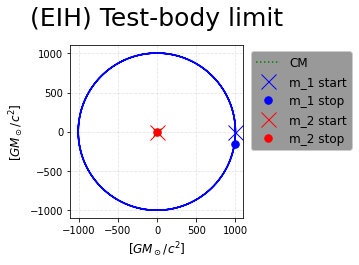

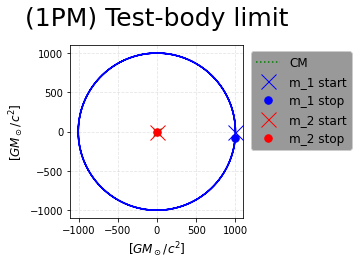

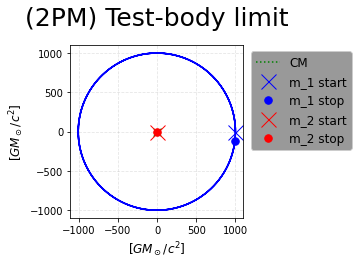

In [32]:
lim = 0
# lims = (-lim, lim)
orbPlotter(positions_EIH, CM = True, xlim=lim, ylim=lim, filename='(EIH) Test-body limit', figsize=(5,5), save=False)
orbPlotter(positions_1PM, CM = True, xlim=lim, ylim=lim, filename='(1PM) Test-body limit', figsize=(5,5), save=False)
orbPlotter(positions_2PM, CM = True, xlim=lim, ylim=lim, filename='(2PM) Test-body limit', figsize=(5,5), save=False)

## 2) Testbody limit w/ Johans initial conditions with eccentricity

In [74]:
m_1 = b1_mass = 1e-4
m_2 = b2_mass = 1

# R_S = 2*(b1_mass + b2_mass)*G/c**2
R_S = 2*(b1_mass + b2_mass)

mass_bin = b1_mass + b2_mass
SMA_bin = 1000


α = 0.5
v_redmass = α*np.sqrt(mass_bin/SMA_bin)
x_1 = CB_b1_posxyz_binCM  = np.array([ (b2_mass/mass_bin)*SMA_bin,  0])
x_2 = CB_b2_posxyz_binCM  = np.array([-(b1_mass/mass_bin)*SMA_bin,  0])
v_1 = CB_b1_velxyz_binCM  = np.array([0, (b2_mass/mass_bin)*v_redmass])
v_2 = CB_b2_velxyz_binCM  = np.array([0,-(b1_mass/mass_bin)*v_redmass])

s = x_1, x_2, v_1, v_2, m_1, m_2
sUnits = x_1*G*M_sun/c**2, x_2*G*M_sun/c**2, v_1*c, v_2*c, m_1*M_sun, m_2*M_sun

V_eff_N   = (TotalEnergy(sUnits, mode = 'N')[1])
V_eff_EIH = (TotalEnergy(sUnits, mode = 'EIH')[1])
V_eff_1PM = (TotalEnergy(sUnits, mode = '1PM')[1])
V_eff_2PM = (TotalEnergy(sUnits, mode = '2PM')[1])
print(f'V_eff_N = {V_eff_N/(M_sun*c**2):.4e} M_sun*c**2 = {V_eff_N:.4e}')
print(f'V_eff_EIH = {V_eff_EIH/(M_sun*c**2):.4e} M_sun*c**2 = {V_eff_EIH:.4e}')
print(f'V_eff_1PM = {V_eff_1PM/(M_sun*c**2):.4e} M_sun*c**2 = {V_eff_1PM:.4e}')
print(f'V_eff_2PM = {V_eff_2PM/(M_sun*c**2):.4e} M_sun*c**2 = {V_eff_2PM:.4e}')


N =  α*6# Number of "years" we want

t_max = 2*np.pi*np.sqrt(SMA_bin**3/(mass_bin))*N
res = 1e5
dt = t_max/res

positions_N = run_model(s, t_max, dt, mode = 'N')
positions_EIH = run_model(s, t_max, dt, mode = 'EIH')
positions_1PM = run_model(s, t_max, dt, mode = '1PM')
positions_2PM = run_model(s, t_max, dt, mode = '2PM')
# print(positions[2])

#~1 min at res=1e5 STABILIZED
#~10 min at res=1e6

V_eff_N = -1.0001e+00 M_sun*c**2 = -1.7873e+47 kg m2 / s2
V_eff_EIH = -1.0001e+00 M_sun*c**2 = -1.7873e+47 kg m2 / s2
V_eff_1PM = -8.7535e-08 M_sun*c**2 = -1.5643e+40 kg m2 / s2
V_eff_2PM = -8.7485e-08 M_sun*c**2 = -1.5634e+40 kg m2 / s2


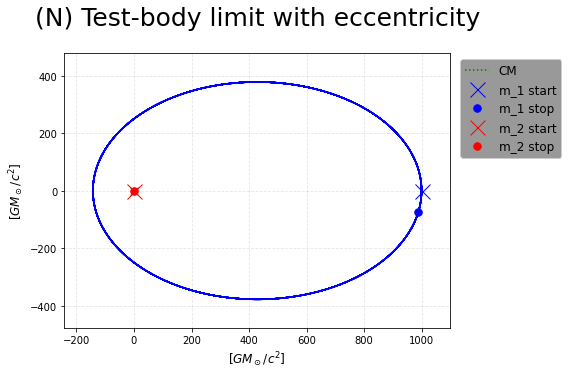

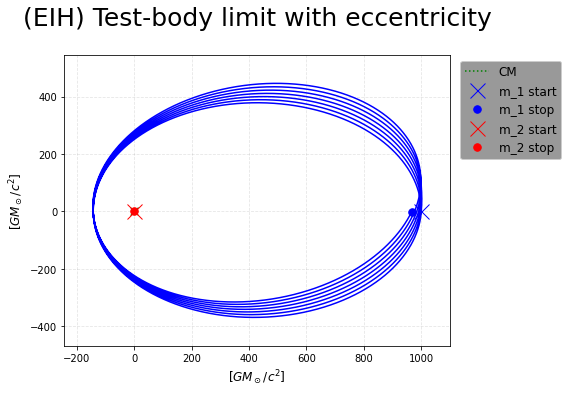

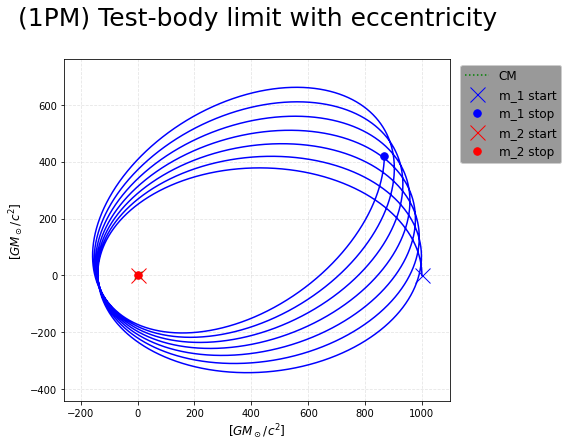

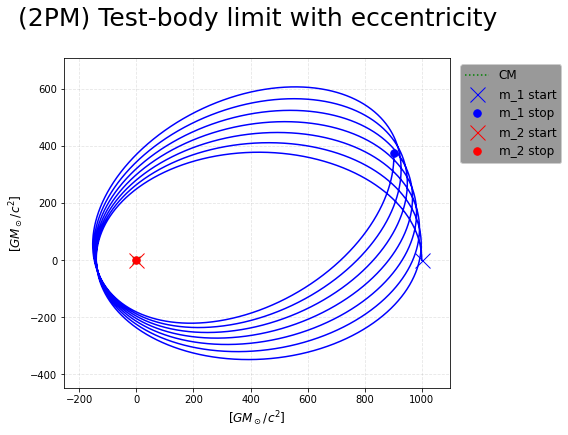

In [76]:
lim = 0
# lims = (-lim, lim)
orbPlotter(positions_N,   CM = True, xlim=lim, ylim=lim, filename='(N) Test-body limit with eccentricity', save=False)
orbPlotter(positions_EIH, CM = True, xlim=lim, ylim=lim, filename='(EIH) Test-body limit with eccentricity', save=False) 
orbPlotter(positions_1PM, CM = True, xlim=lim, ylim=lim, filename='(1PM) Test-body limit with eccentricity', save=False)
orbPlotter(positions_2PM, CM = True, xlim=lim, ylim=lim, filename='(2PM) Test-body limit with eccentricity', save=False)

The perihelionShift in the three cases are (N:) 0.002°, (EIH:) 1.362°, (1PM): 5.137°, (2PM): 4.278°


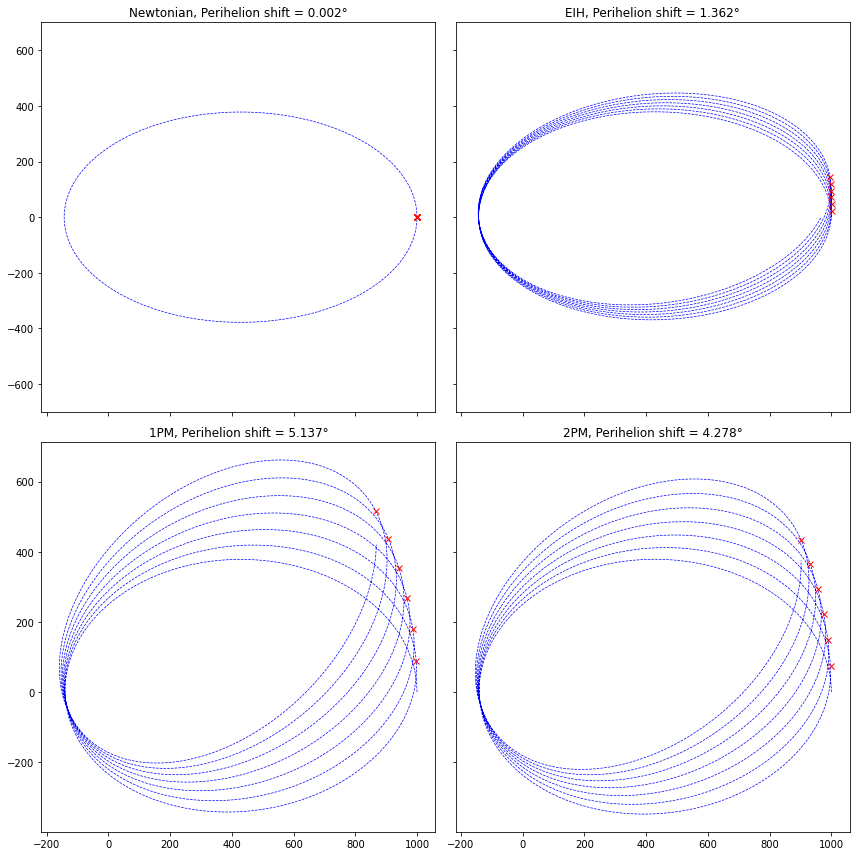

In [77]:
rs_N, peakPositions_N, peakAngles_N, perihelionShift_N = perihelionShift(positions_N[0]) 
rs_EIH, peakPositions_EIH, peakAngles_EIH, perihelionShift_EIH = perihelionShift(positions_EIH[0]) 
rs_1PM, peakPositions_1PM, peakAngles_1PM, perihelionShift_1PM = perihelionShift(positions_1PM[0])    
rs_2PM, peakPositions_2PM, peakAngles_2PM, perihelionShift_2PM = perihelionShift(positions_2PM[0])


fig, axs = plt.subplots(2,2, figsize=(12,12), sharex = True, sharey = 'row')

axs[0,0].plot(positions_N[0,0][0:14300], positions_N[0,1][0:14300], 'b--', lw=0.7)
axs[0,0].set_title(f'Newtonian, Perihelion shift = {perihelionShift_N*180/np.pi:.3f}°')
axs[0,0].set_ylim(-700, 700)

axs[0,1].plot(positions_EIH[0,0], positions_EIH[0,1], 'b--', lw=0.7)
axs[0,1].set_title(f'EIH, Perihelion shift = {perihelionShift_EIH*180/np.pi:.3f}°')
# axs[0,0].setp(ax, ylim=ax[0,0].get_ylim())

axs[1,0].plot(positions_1PM[0,0], positions_1PM[0,1], 'b--', lw=0.7)
axs[1,0].set_title(f'1PM, Perihelion shift = {perihelionShift_1PM*180/np.pi:.3f}°')

axs[1,1].plot(positions_2PM[0,0], positions_2PM[0,1], 'b--', lw=0.7)
axs[1,1].set_title(f'2PM, Perihelion shift = {perihelionShift_2PM*180/np.pi:.3f}°')

for i in range(len(peakPositions_EIH)):
    axs[0,0].plot(peakPositions_N[i,0], peakPositions_N[i,1], 'rx')
    axs[0,1].plot(peakPositions_EIH[i,0], peakPositions_EIH[i,1], 'rx')
    axs[1,0].plot(peakPositions_1PM[i,0], peakPositions_1PM[i,1], 'rx')
    axs[1,1].plot(peakPositions_2PM[i,0], peakPositions_2PM[i,1], 'rx')
print(f'The perihelionShift in the three cases are (N:) {perihelionShift_N*180/np.pi:.3f}°, (EIH:) {perihelionShift_EIH*180/np.pi:.3f}°, (1PM): {perihelionShift_1PM*180/np.pi:.3f}°, (2PM): {perihelionShift_2PM*180/np.pi:.3f}°')
fig.tight_layout()
# fig.savefig('test body perihelion shift.jpg', dpi=600)

    
    

In [79]:
G = const.G
c = const.c

x_1, x_2, v_1, v_2, m_1, m_2 = sUnits

δxN = np.abs(max(positions_N[0,0][0:14300]) - min(positions_N[0,0][0:14300]))
δyN = np.abs(max(positions_N[0,1][0:14300]) - min(positions_N[0,1][0:14300]))

a_N = max(δxN/2, δyN/2)*M_sun*G/c**2
b_N = min(δxN/2, δyN/2)*M_sun*G/c**2

e = np.sqrt(1 - b_N**2/a_N**2)

# Calculating the analytically predicted value of the precession angle (in radians), and how many times it divides 2π radians.
Δφr = 6*G*np.pi*(m_1 + m_2)/((1 - e**2)*a_N*c**2)
Δφa = Δφr*180/np.pi #Convert to angles
print(f'Δφ (in radians) = {Δφr:.3f}, Δφ (in angles) = {Δφa:.3f}')


M = m_1 + m_2
μ = m_1*m_2/M
ν = μ/M

v_vec = v_1 - v_2
γ_1 = 1/np.sqrt(1 - np.dot(v_1,v_1)/c**2)
γ_rel = 1/np.sqrt(1 - np.dot(v_vec,v_vec)/c**2)

E = M*np.sqrt(1 + 2*ν*(γ_rel - 1))*c**2

r_vec = x_1 - x_2
p_vec = m_1*γ_rel*v_1
J_vec = np.cross(r_vec, p_vec)
J = np.linalg.norm(J_vec)


ΔΦr_poul = 3/2*np.pi*(G*M*μ/(J*c))**2*(E/(M*c**2))*(5*γ_rel**2 - 1)
ΔΦa_poul = ΔΦr_poul*180/np.pi
print(f'ΔΦ_poul (in radians) = {ΔΦr_poul:.3f}, ΔΦ_poul (in angles) = {ΔΦa_poul:.3f}')

Δφ (in radians) = 0.075, Δφ (in angles) = 4.321
ΔΦ_poul (in radians) = 0.075, ΔΦ_poul (in angles) = 4.321


## 3) Similar mass binary system

In [80]:
m_1 = b1_mass = 2
m_2 = b2_mass = 2

R_S = 2*(b1_mass + b2_mass)*G/c**2

mass_bin = b1_mass + b2_mass
SMA_bin = 1000
v_redmass = np.sqrt(mass_bin/SMA_bin)
x_1 = CB_b1_posxyz_binCM  = np.array([ (b2_mass/mass_bin)*SMA_bin,  0])
x_2 = CB_b2_posxyz_binCM  = np.array([-(b1_mass/mass_bin)*SMA_bin,  0])
v_1 = CB_b1_velxyz_binCM  = np.array([0, (b2_mass/mass_bin)*v_redmass])
v_2 = CB_b2_velxyz_binCM  = np.array([0,-(b1_mass/mass_bin)*v_redmass])

s = x_1, x_2, v_1, v_2, m_1, m_2
sUnits = x_1*G*M_sun/c**2, x_2*G*M_sun/c**2, v_1*c, v_2*c, m_1*M_sun, m_2*M_sun

V_eff_N   = (TotalEnergy(sUnits, mode = 'N')[1])
V_eff_EIH = (TotalEnergy(sUnits, mode = 'EIH')[1])
V_eff_1PM = (TotalEnergy(sUnits, mode = '1PM')[1])
V_eff_2PM = (TotalEnergy(sUnits, mode = '2PM')[1])
print(f'V_eff_N = {V_eff_N/(M_sun*c**2):.4e} M_sun*c**2 = {V_eff_N:.4e}')
print(f'V_eff_EIH = {V_eff_EIH/(M_sun*c**2):.4e} M_sun*c**2 = {V_eff_EIH:.4e}')
print(f'V_eff_1PM = {V_eff_1PM/(M_sun*c**2):.4e} M_sun*c**2 = {V_eff_1PM:.4e}')
print(f'V_eff_2PM = {V_eff_2PM/(M_sun*c**2):.4e} M_sun*c**2 = {V_eff_2PM:.4e}')


N = 2 # Number of "years" we want

t_max = 2*np.pi*np.sqrt(SMA_bin**3/(mass_bin))*N
res = 1e5
dt = t_max/res

positions_N = run_model(s, t_max, dt, mode = 'N')
positions_EIH = run_model(s, t_max, dt, mode = 'EIH')
positions_1PM = run_model(s, t_max, dt, mode = '1PM')
positions_2PM = run_model(s, t_max, dt, mode = '2PM')
# print(positions[2])

#~1 min at res=1e5 STABILIZED
#~10 min at res=1e6

#~1 min at res=1e5

V_eff_N = -4.0000e+00 M_sun*c**2 = -7.1484e+47 kg m2 / s2
V_eff_EIH = -4.0020e+00 M_sun*c**2 = -7.1520e+47 kg m2 / s2
V_eff_1PM = -2.0265e-03 M_sun*c**2 = -3.6216e+44 kg m2 / s2
V_eff_2PM = -2.0163e-03 M_sun*c**2 = -3.6032e+44 kg m2 / s2


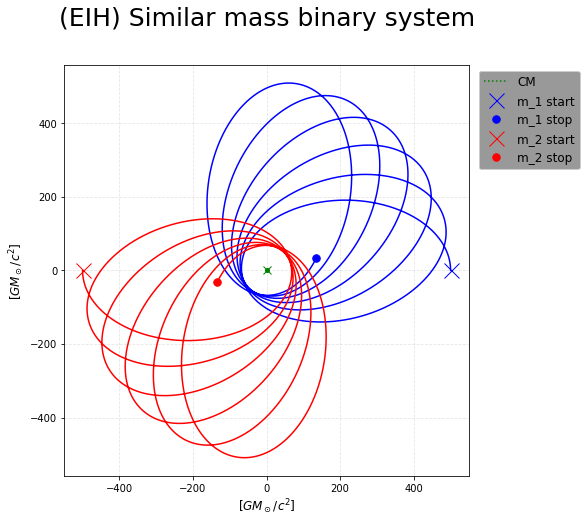

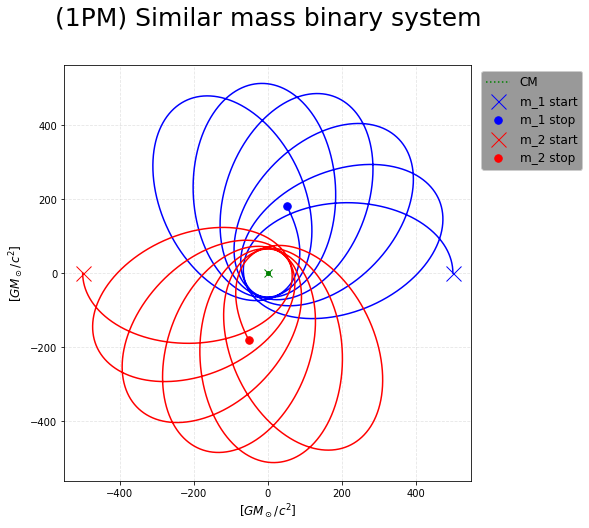

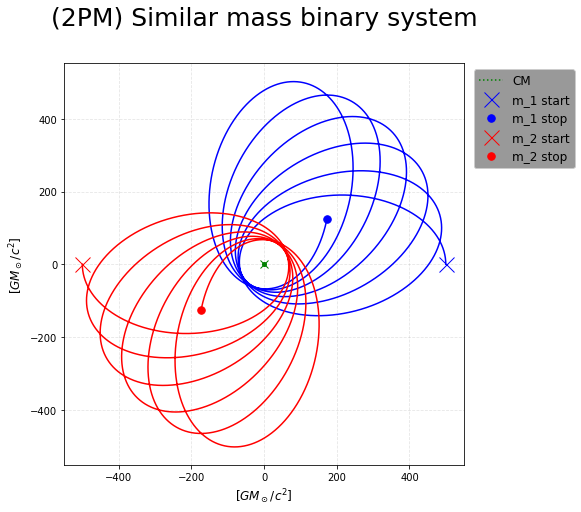

In [86]:
# lim = 500
# orbPlotter(positions, DL = True, xlim=(-lim,lim), ylim=(-lim,lim))

orbPlotter(positions_EIH, CM = True, filename='(EIH) Similar mass binary system', save=False)
orbPlotter(positions_1PM, CM = True, filename='(1PM) Similar mass binary system', save=False)
orbPlotter(positions_2PM, CM = True, filename='(2PM) Similar mass binary system', save=False)

The perihelionShift in the three cases are (N:) 0.002°, (EIH:) 16.193°, (1PM): 23.069°, (2PM): 15.546°


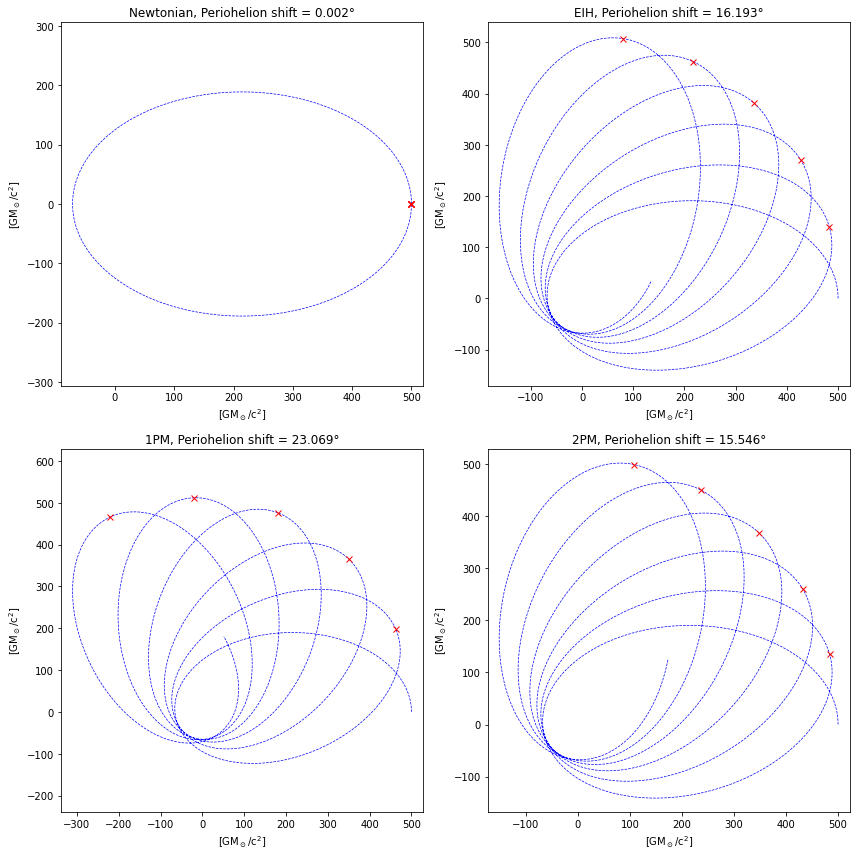

In [99]:
rs_N, peakPositions_N, peakAngles_N, perihelionShift_N = perihelionShift(positions_N[0])
rs_EIH, peakPositions_EIH, peakAngles_EIH, perihelionShift_EIH = perihelionShift(positions_EIH[0]) 
rs_1PM, peakPositions_1PM, peakAngles_1PM, perihelionShift_1PM = perihelionShift(positions_1PM[0])    
rs_2PM, peakPositions_2PM, peakAngles_2PM, perihelionShift_2PM = perihelionShift(positions_2PM[0])


fig, axs = plt.subplots(2,2, figsize=(12,12))



axs[0,0].set_aspect('equal', adjustable='datalim')
axs[0,0].plot(positions_N[0,0][0:17300], positions_N[0,1][0:17300], 'b--', lw=0.7)
axs[0,0].set_title(f'Newtonian, Periohelion shift = {perihelionShift_N*180/np.pi:.3f}°')
axs[0,0].set_xlabel('$\mathrm{[G M_\odot/c^2]}$')
axs[0,0].set_ylabel('$\mathrm{[G M_\odot/c^2]}$')

axs[0,1].set_aspect('equal', adjustable='datalim')
axs[0,1].plot(positions_EIH[0,0], positions_EIH[0,1], 'b--', lw=0.7)
axs[0,1].set_title(f'EIH, Periohelion shift = {perihelionShift_EIH*180/np.pi:.3f}°')
axs[0,1].set_xlabel('$\mathrm{[G M_\odot/c^2]}$')
axs[0,1].set_ylabel('$\mathrm{[G M_\odot/c^2]}$')

axs[1,0].set_aspect('equal', adjustable='datalim')
axs[1,0].plot(positions_1PM[0,0], positions_1PM[0,1], 'b--', lw=0.7)
axs[1,0].set_title(f'1PM, Periohelion shift = {perihelionShift_1PM*180/np.pi:.3f}°')
axs[1,0].set_xlabel('$\mathrm{[G M_\odot/c^2]}$')
axs[1,0].set_ylabel('$\mathrm{[G M_\odot/c^2]}$')

axs[1,1].set_aspect('equal', adjustable='datalim')
axs[1,1].plot(positions_2PM[0,0], positions_2PM[0,1], 'b--', lw=0.7)
axs[1,1].set_title(f'2PM, Periohelion shift = {perihelionShift_2PM*180/np.pi:.3f}°')
axs[1,1].set_xlabel('$\mathrm{[G M_\odot/c^2]}$')
axs[1,1].set_ylabel('$\mathrm{[G M_\odot/c^2]}$')

for i in range(len(peakPositions_EIH)):
    axs[0,0].plot(peakPositions_N[i,0], peakPositions_N[i,1], 'rx')
    axs[0,1].plot(peakPositions_EIH[i,0], peakPositions_EIH[i,1], 'rx')
    axs[1,0].plot(peakPositions_1PM[i,0], peakPositions_1PM[i,1], 'rx')
    axs[1,1].plot(peakPositions_2PM[i,0], peakPositions_2PM[i,1], 'rx')
print(f'The perihelionShift in the three cases are (N:) {perihelionShift_N*180/np.pi:.3f}°, (EIH:) {perihelionShift_EIH*180/np.pi:.3f}°, (1PM): {perihelionShift_1PM*180/np.pi:.3f}°, (2PM): {perihelionShift_2PM*180/np.pi:.3f}°')
fig.tight_layout()
# fig.savefig('similar mass perihelion shift.jpg', dpi=600)
    
    

In [95]:
G = const.G
c = const.c

x_1, x_2, v_1, v_2, m_1, m_2 = sUnits

δxN = np.abs(max(positions_N[0,0][0:14300]) - min(positions_N[0,0][0:14300]))
δyN = np.abs(max(positions_N[0,1][0:14300]) - min(positions_N[0,1][0:14300]))

a_N = max(δxN/2, δyN/2)*M_sun*G/c**2
b_N = min(δxN/2, δyN/2)*M_sun*G/c**2

e = np.sqrt(1 - b_N**2/a_N**2)

# Calculating the analytically predicted value of the precession angle (in radians), and how many times it divides 2π radians.
Δφr = 6*G*np.pi*(m_1 + m_2)/((1 - e**2)*a_N*c**2)
Δφa = Δφr*180/np.pi #Convert to angles
print(f'Δφ (in radians) = {Δφr:.3f}, Δφ (in angles) = {Δφa:.3f}')


M = m_1 + m_2
μ = m_1*m_2/M
ν = μ/M

v_vec = v_1 - v_2
γ_1 = 1/np.sqrt(1 - np.dot(v_1,v_1)/c**2)
γ_rel = 1/np.sqrt(1 - np.dot(v_vec,v_vec)/c**2)

E = M*np.sqrt(1 + 2*ν*(γ_1 - 1))*c**2

r_vec = x_1 - x_2
p_vec = m_1*γ_1*v_1
J_vec = np.cross(r_vec, p_vec)
J = np.linalg.norm(J_vec)


ΔΦr_poul = 3/2*np.pi*(G*M*μ/(J*c))**2*(E/(M*c**2))*(5*γ_1**2 - 1)
ΔΦa_poul = ΔΦr_poul*180/np.pi
print(f'ΔΦ_poul (in radians) = {ΔΦr_poul:.3f}, ΔΦ_poul (in angles) = {ΔΦa_poul:.3f}')

Δφ (in radians) = 0.603, Δφ (in angles) = 34.560
ΔΦ_poul (in radians) = 0.302, ΔΦ_poul (in angles) = 17.282


## 4) Similar mass binary system w/ eccentricty (hopefully)

In [82]:
m_1 = b1_mass = 2
m_2 = b2_mass = 2

R_S = 2*(b1_mass + b2_mass)*G/c**2

mass_bin = b1_mass + b2_mass
SMA_bin = 1000

α = 0.5
v_redmass = α*np.sqrt(mass_bin/SMA_bin)
x_1 = CB_b1_posxyz_binCM  = np.array([ (b2_mass/mass_bin)*SMA_bin,  0])
x_2 = CB_b2_posxyz_binCM  = np.array([-(b1_mass/mass_bin)*SMA_bin,  0])
v_1 = CB_b1_velxyz_binCM  = np.array([0, (b2_mass/mass_bin)*v_redmass])
v_2 = CB_b2_velxyz_binCM  = np.array([0,-(b1_mass/mass_bin)*v_redmass])

s = x_1, x_2, v_1, v_2, m_1, m_2
sUnits = x_1*G*M_sun/c**2, x_2*G*M_sun/c**2, v_1*c, v_2*c, m_1*M_sun, m_2*M_sun

V_eff_N   = (TotalEnergy(sUnits, mode = 'N')[1])
V_eff_EIH = (TotalEnergy(sUnits, mode = 'EIH')[1])
V_eff_1PM = (TotalEnergy(sUnits, mode = '1PM')[1])
V_eff_2PM = (TotalEnergy(sUnits, mode = '2PM')[1])
print(f'V_eff_N = {V_eff_N/(M_sun*c**2):.4e} M_sun*c**2 = {V_eff_N:.4e}')
print(f'V_eff_EIH = {V_eff_EIH/(M_sun*c**2):.4e} M_sun*c**2 = {V_eff_EIH:.4e}')
print(f'V_eff_1PM = {V_eff_1PM/(M_sun*c**2):.4e} M_sun*c**2 = {V_eff_1PM:.4e}')
print(f'V_eff_2PM = {V_eff_2PM/(M_sun*c**2):.4e} M_sun*c**2 = {V_eff_2PM:.4e}')


N =  α*5# Number of "years" we want

t_max = 2*np.pi*np.sqrt(SMA_bin**3/(mass_bin))*N
res = 1e5
dt = t_max/res

positions_N = run_model(s, t_max, dt, mode = 'N')
positions_EIH = run_model(s, t_max, dt, mode = 'EIH')
positions_1PM = run_model(s, t_max, dt, mode = '1PM')
positions_2PM = run_model(s, t_max, dt, mode = '2PM')

#~1 min at res=1e5

V_eff_N = -4.0030e+00 M_sun*c**2 = -7.1537e+47 kg m2 / s2
V_eff_EIH = -4.0035e+00 M_sun*c**2 = -7.1546e+47 kg m2 / s2
V_eff_1PM = -3.5069e-03 M_sun*c**2 = -6.2672e+44 kg m2 / s2
V_eff_2PM = -3.4968e-03 M_sun*c**2 = -6.2492e+44 kg m2 / s2


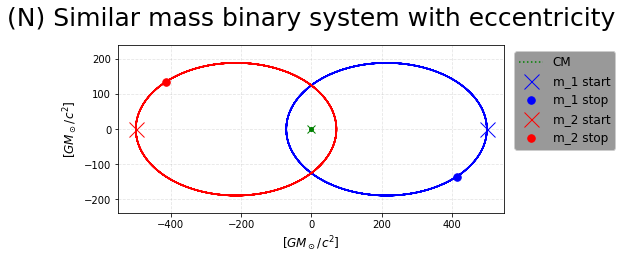

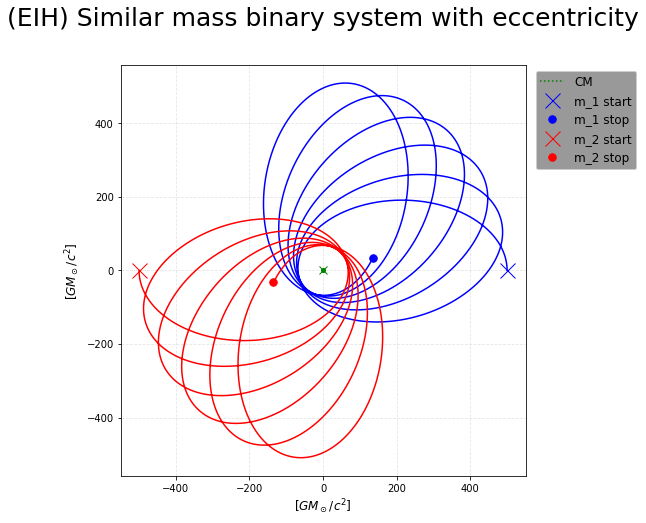

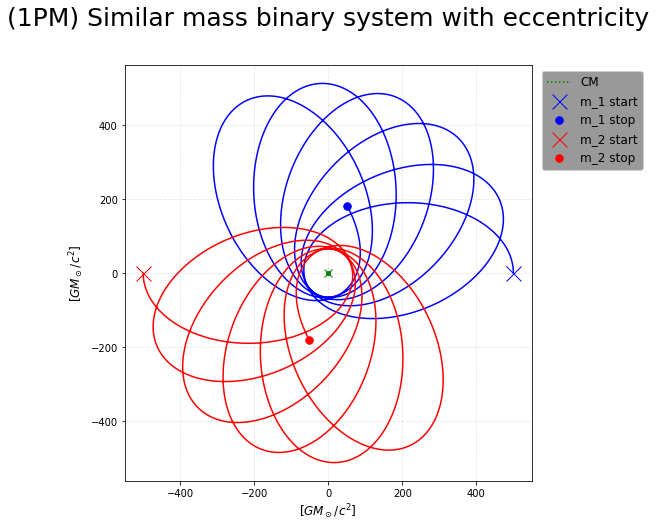

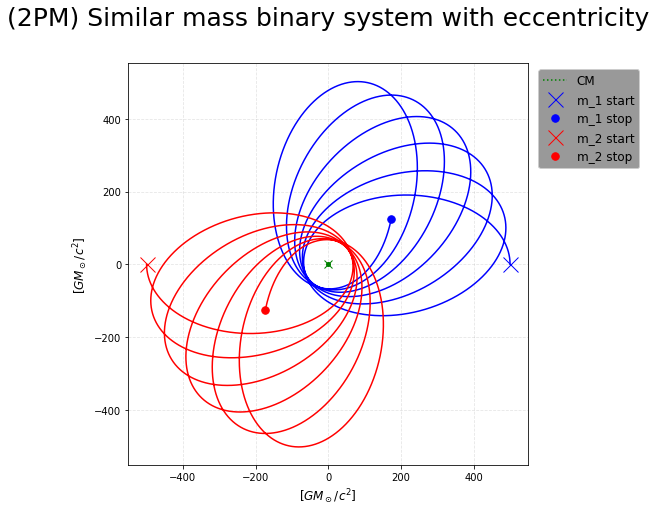

In [83]:
# lim = 500
# orbPlotter(positions, DL = True, xlim=(-lim,lim), ylim=(-lim,lim))

orbPlotter(positions_N, CM = False, filename='(N) Similar mass binary system with eccentricity', save=False)
orbPlotter(positions_EIH, CM = False, filename='(EIH) Similar mass binary system with eccentricity', save=False)
orbPlotter(positions_1PM, CM = False, filename='(1PM) Similar mass binary system with eccentricity', save=False)
orbPlotter(positions_2PM, CM = False, filename='(2PM) Similar mass binary system with eccentricity', save=False)

The perihelionShift in the three cases are (N:) 0.002°, (EIH:) 16.193°, (1PM): 23.069°, (2PM): 15.546°


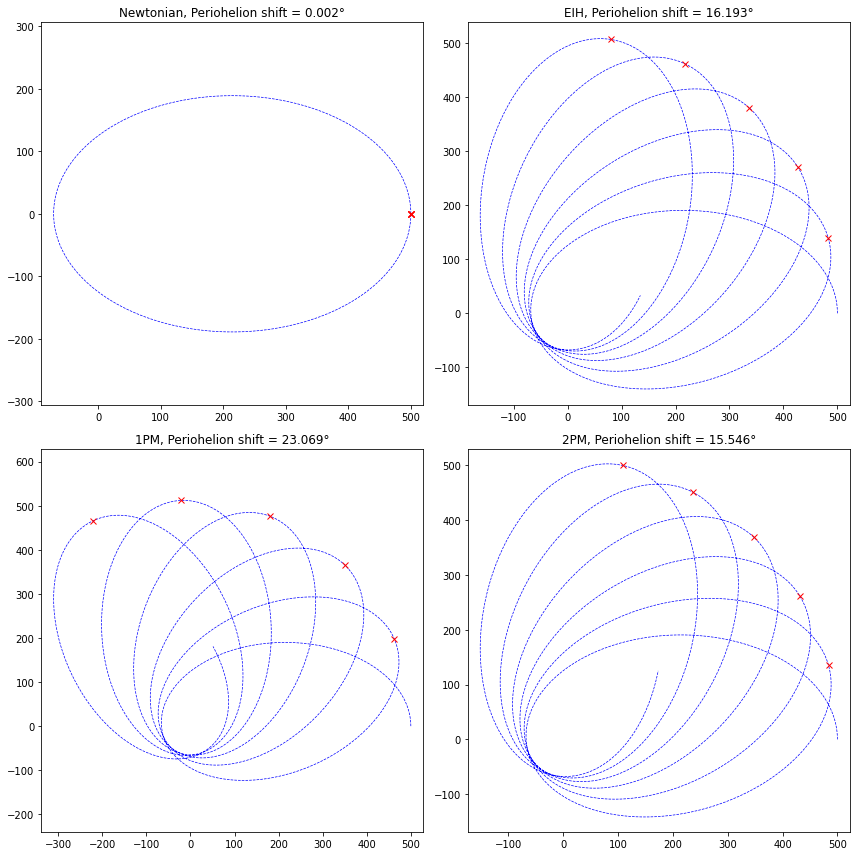

In [84]:
rs_N, peakPositions_N, peakAngles_N, perihelionShift_N = perihelionShift(positions_N[0])
rs_EIH, peakPositions_EIH, peakAngles_EIH, perihelionShift_EIH = perihelionShift(positions_EIH[0]) 
rs_1PM, peakPositions_1PM, peakAngles_1PM, perihelionShift_1PM = perihelionShift(positions_1PM[0])    
rs_2PM, peakPositions_2PM, peakAngles_2PM, perihelionShift_2PM = perihelionShift(positions_2PM[0])


fig, axs = plt.subplots(2,2, figsize=(12,12))



axs[0,0].set_aspect('equal', adjustable='datalim')
axs[0,0].plot(positions_N[0,0][0:17300], positions_N[0,1][0:17300], 'b--', lw=0.7)
axs[0,0].set_title(f'Newtonian, Periohelion shift = {perihelionShift_N*180/np.pi:.3f}°')

axs[0,1].set_aspect('equal', adjustable='datalim')
axs[0,1].plot(positions_EIH[0,0], positions_EIH[0,1], 'b--', lw=0.7)
axs[0,1].set_title(f'EIH, Periohelion shift = {perihelionShift_EIH*180/np.pi:.3f}°')

axs[1,0].set_aspect('equal', adjustable='datalim')
axs[1,0].plot(positions_1PM[0,0], positions_1PM[0,1], 'b--', lw=0.7)
axs[1,0].set_title(f'1PM, Periohelion shift = {perihelionShift_1PM*180/np.pi:.3f}°')

axs[1,1].set_aspect('equal', adjustable='datalim')
axs[1,1].plot(positions_2PM[0,0], positions_2PM[0,1], 'b--', lw=0.7)
axs[1,1].set_title(f'2PM, Periohelion shift = {perihelionShift_2PM*180/np.pi:.3f}°')

for i in range(len(peakPositions_EIH)):
    axs[0,0].plot(peakPositions_N[i,0], peakPositions_N[i,1], 'rx')
    axs[0,1].plot(peakPositions_EIH[i,0], peakPositions_EIH[i,1], 'rx')
    axs[1,0].plot(peakPositions_1PM[i,0], peakPositions_1PM[i,1], 'rx')
    axs[1,1].plot(peakPositions_2PM[i,0], peakPositions_2PM[i,1], 'rx')
print(f'The perihelionShift in the three cases are (N:) {perihelionShift_N*180/np.pi:.3f}°, (EIH:) {perihelionShift_EIH*180/np.pi:.3f}°, (1PM): {perihelionShift_1PM*180/np.pi:.3f}°, (2PM): {perihelionShift_2PM*180/np.pi:.3f}°')
fig.tight_layout()
# fig.savefig('similar mass perihelion shift.jpg', dpi=600)
    
    

In [85]:
G = const.G
c = const.c

x_1, x_2, v_1, v_2, m_1, m_2 = sUnits

δxN = np.abs(max(positions_N[0,0][0:14300]) - min(positions_N[0,0][0:14300]))
δyN = np.abs(max(positions_N[0,1][0:14300]) - min(positions_N[0,1][0:14300]))

a_N = max(δxN/2, δyN/2)*M_sun*G/c**2
b_N = min(δxN/2, δyN/2)*M_sun*G/c**2

e = np.sqrt(1 - b_N**2/a_N**2)

# Calculating the analytically predicted value of the precession angle (in radians), and how many times it divides 2π radians.
Δφr = 6*G*np.pi*(m_1 + m_2)/((1 - e**2)*a_N*c**2)
Δφa = Δφr*180/np.pi #Convert to angles
print(f'Δφ (in radians) = {Δφr:.3f}, Δφ (in angles) = {Δφa:.3f}')


M = m_1 + m_2
μ = m_1*m_2/M
ν = μ/M

v_vec = v_1 - v_2
γ_1 = 1/np.sqrt(1 - np.dot(v_1,v_1)/c**2)
γ_rel = 1/np.sqrt(1 - np.dot(v_vec,v_vec)/c**2)

E = M*np.sqrt(1 + 2*ν*(γ_rel - 1))*c**2

r_vec = x_1 - x_2
p_vec = m_1*γ_rel*v_1
J_vec = np.cross(r_vec, p_vec)
J = np.linalg.norm(J_vec)


ΔΦr_poul = 3/2*np.pi*(G*M*μ/(J*c))**2*(E/(M*c**2))*(5*γ_rel**2 - 1)
ΔΦa_poul = ΔΦr_poul*180/np.pi
print(f'ΔΦ_poul (in radians) = {ΔΦr_poul:.3f}, ΔΦ_poul (in angles) = {ΔΦa_poul:.3f}')

Δφ (in radians) = 0.603, Δφ (in angles) = 34.560
ΔΦ_poul (in radians) = 0.302, ΔΦ_poul (in angles) = 17.286


# SCATTERING

In [22]:
m_1 = 1e-6
m_2 = 5

R_S = 2*(m_1 + m_2)

x_1 = np.array([-1e4, 500.])
x_2 = np.array([0.,    0.])
v_1 = np.array([0.9,   0.])
v_2 = np.array([0.,    0.])
s = x_1, x_2, v_1, v_2, m_1, m_2
sUnits = x_1*G*M_sun/c**2, x_2*G*M_sun/c**2, v_1*c, v_2*c, m_1*M_sun, m_2*M_sun


t_max = 2e4
res = 3e4
dt = t_max/res

# positions_EIH = run_model(s, t_max, dt, DL = True, mode = 'EIH', scattering=True)
# positions_1PM = run_model(s, t_max, dt, DL = True, mode = '1PM', scattering=True)
# positions_2PM = run_model(s, t_max, dt, DL = True, mode = '2PM', scattering=True)

positions_N = run_model(s, t_max, dt, mode = 'N')
positions_EIH = run_model(s, t_max, dt, mode = 'EIH')
positions_1PM = run_model(s, t_max, dt, mode = '1PM')
positions_2PM = run_model(s, t_max, dt, mode = '2PM')


# For the graph in the paper
# m_1 = 1e-6
# m_2 = 5

# R_S = 2*(m_1 + m_2)

# x_1 = np.array([-3e3, 400.])
# x_2 = np.array([0.,    0.])
# v_1 = np.array([0.4,   0.])
# v_2 = np.array([0.,    0.])

In [23]:
m_1 = 1e-6
m_2 = 5

R_S = 2*(m_1 + m_2)

x_1 = np.array([-1e4, 500.])
x_2 = np.array([0.,    0.])
v_1 = np.array([0.9,   0.])
v_2 = np.array([0.,    0.])
s = x_1, x_2, v_1, v_2, m_1, m_2

V_eff_N = TotalEnergy(sUnits, mode = 'N')[1]
V_eff_EIH= TotalEnergy(sUnits, mode = 'EIH')[1]
V_eff_1PM = TotalEnergy(sUnits, mode = '1PM')[1]
V_eff_2PM = TotalEnergy(sUnits, mode = '2PM')[1]

print(f'V_eff_N = {V_eff_N:.2e}')
print(f'V_eff_EIH = {V_eff_EIH:.2e}')
print(f'V_eff_1PM = {V_eff_1PM:.2e}')
print(f'V_eff_2PM = {V_eff_2PM:.2e}')

V_eff_N = -8.94e+47 kg m2 / s2
V_eff_EIH = -8.94e+47 kg m2 / s2
V_eff_1PM = 2.31e+41 kg m2 / s2
V_eff_2PM = 2.31e+41 kg m2 / s2


In [26]:
θ_N = scatteringAngle_analytical(sUnits, mode = 'N')
θ_1PM = scatteringAngle_analytical(sUnits, mode = '1PM')
θ_2PM = scatteringAngle_analytical(sUnits, mode = '2PM')

θ_N, θ_1PM, θ_2PM, θ_1PM + θ_N, θ_2PM + θ_N

TypeError: only dimensionless scalar quantities can be converted to Python scalars

In [ ]:
lim = 1.2e4
# lims = 0
lims = (-lim,lim)
orbPlotter(positions_N, DL = True, CM = True, filename='(N) Test-body limit scattering', xlim=lims, ylim=lims, save=False)
orbPlotter(positions_EIH, DL = True, CM = True, filename='(EIH) Test-body limit scattering', xlim=lims, ylim=lims, save=False)
orbPlotter(positions_1PM, DL = True, CM = True, filename='(1PM) Test-body limit scattering', xlim=lims, ylim=lims, save=False)
orbPlotter(positions_2PM, DL = True, CM = True, filename='(2PM) Test-body limit scattering', xlim=lims, ylim=lims, save=False)

print(f'θ_N = {scatteringAngle(positions_N):.2f}°')
print(f'θ_EIH = {scatteringAngle(positions_EIH):.2f}°')
print(f'θ_1PM = {scatteringAngle(positions_1PM):.2f}°')
print(f'θ_2PM = {scatteringAngle(positions_2PM):.2f}°')

In [ ]:
positions_2PM[0,:,0], positions_2PM[0,:,-1]

In [ ]:
fig, axs = plt.subplots(2,2, figsize=(12,6), sharex = True, sharey = True)


axs[0,0].plot(positions_N[0,0], positions_N[0,1], 'b--', lw=0.7)
axs[0,0].plot(0,0,'r.')
axs[0,0].plot(positions_N[0,0][-1], positions_N[0,1][-1], 'bo')
axs[0,0].plot(positions_N[0,0][0], positions_N[0,1][0], 'bx')
axs[0,0].set_title(f'θ_Newtonian = {scatteringAngle(positions_N):.2f}°')
axs[0,0].set_ylim(-350, 1700)

axs[0,1].plot(positions_EIH[0,0], positions_EIH[0,1], 'b--', lw=0.7)
axs[0,1].plot(0,0,'r.')
axs[0,1].plot(positions_EIH[0,0][-1], positions_EIH[0,1][-1], 'bo')
axs[0,1].plot(positions_EIH[0,0][0], positions_EIH[0,1][0], 'bx')
axs[0,1].set_title(f'θ_EIH = {scatteringAngle(positions_EIH):.2f}°')

axs[1,0].plot(positions_1PM[0,0], positions_1PM[0,1], 'b--', lw=0.7)
axs[1,0].plot(0,0,'r.')
axs[1,0].plot(positions_1PM[0,0][-1], positions_1PM[0,1][-1], 'bo')
axs[1,0].plot(positions_1PM[0,0][0], positions_1PM[0,1][0], 'bx')
axs[1,0].set_title(f'θ_1PM = {scatteringAngle(positions_1PM):.2f}°')

axs[1,1].plot(positions_2PM[0,0], positions_2PM[0,1], 'b--', lw=0.7)
axs[1,1].plot(0,0,'r.')
axs[1,1].plot(positions_2PM[0,0][-1], positions_2PM[0,1][-1], 'bo')
axs[1,1].plot(positions_2PM[0,0][0], positions_2PM[0,1][0], 'bx')
axs[1,1].set_title(f'θ_2PM = {scatteringAngle(positions_2PM):.2f}°')
# for i in range(len(peakPositions_EIH)):
#     axs[0,0].plot(peakPositions_N[i,0], peakPositions_N[i,1], 'rx')
#     axs[0,1].plot(peakPositions_EIH[i,0], peakPositions_EIH[i,1], 'rx')
#     axs[1,0].plot(peakPositions_1PM[i,0], peakPositions_1PM[i,1], 'rx')
#     axs[1,1].plot(peakPositions_2PM[i,0], peakPositions_2PM[i,1], 'rx')
fig.tight_layout()
# fig.savefig('test body scattering 2.jpg', dpi=600)


In [11]:
m_1 = 1e-6
m_2 = 1

R_S = 2*(m_1 + m_2)

x_1 = np.array([-1e4, 400.])
x_2 = np.array([0.,    0.])
v_1 = np.array([0.3,   0.])
v_2 = np.array([0.,    0.])
s = x_1, x_2, v_1, v_2, m_1, m_2


t_max = 5e4
res = 1e4
dt = t_max/res

leng = 11

θs_N = np.zeros(leng)
θs_N_an = np.zeros(leng)
Ls_N = np.zeros(leng)

θs_EIH = np.zeros(leng)
θs_EIH_an = np.zeros(leng)
Ls_EIH = np.zeros(leng)

θs_1PM = np.zeros(leng)
θs_1PM_an = np.zeros(leng)
Ls_1PM = np.zeros(leng)

θs_2PM = np.zeros(leng)
θs_2PM_an = np.zeros(leng)
Ls_2PM = np.zeros(leng)


for i in range(leng):
    v_1 = np.array([0.3,   0.])
    v_1 += np.array([0.03*i, 0])
    print(v_1)
    s = x_1, x_2, v_1, v_2, m_1, m_2

    positions_N = run_model(s, t_max, dt, mode = 'N')
    positions_EIH = run_model(s, t_max, dt, mode = 'EIH')
    positions_1PM = run_model(s, t_max, dt, mode = '1PM')
    positions_2PM = run_model(s, t_max, dt, mode = '2PM')

    θs_N[i] = scatteringAngle(positions_N)
    θs_N_an[i], Ls_N[i] = scatteringAngle_analytical(s, mode ='N')

    θs_EIH[i] = scatteringAngle(positions_EIH)
    Ls_EIH[i] = scatteringAngle_analytical(s, mode ='N')[1]

    θs_1PM[i] = scatteringAngle(positions_1PM)
    θs_1PM_an[i], Ls_1PM[i] = scatteringAngle_analytical(s, mode ='1PM')

    θs_2PM[i] = scatteringAngle(positions_2PM)
    θs_2PM_an[i], Ls_2PM[i] = scatteringAngle_analytical(s, mode ='2PM')

# 5m 5s at res = 3e4


[0.3 0. ]


UnitConversionError: Can only apply 'add' function to quantities with compatible dimensions

In [ ]:
m_1 = 1e-6
m_2 = 1

R_S = 2*(m_1 + m_2)

x_1 = np.array([-1e4, 400.])
x_2 = np.array([0.,    0.])
v_1 = np.array([0.3,   0.])
v_2 = np.array([0.,    0.])
s = x_1, x_2, v_1, v_2, m_1, m_2


t_max = 5e4
res = 1e4
dt = t_max/res

leng = 11

θ_test = np.zeros(leng)


for i in range(leng):
    v_1 = np.array([0.3,   0.])
    v_1 += np.array([0.03*i, 0])
    print(v_1)
    s = x_1, x_2, v_1, v_2, m_1, m_2

    θ_test[i] = otherScatteringAngleAnalytical(s, DL = True)

In [ ]:
θ_test, θs_2PM_an

In [ ]:
fig, axs = plt.subplots(2,2, figsize=(12,6), sharex = True, sharey = True)


axs[0,0].plot(positions_N[0,0], positions_N[0,1], 'b--', lw=0.7)
axs[0,0].plot(0,0,'r.')
axs[0,0].plot(positions_N[0,0][-1], positions_N[0,1][-1], 'bo')
axs[0,0].plot(positions_N[0,0][0], positions_N[0,1][0], 'bx')
axs[0,0].set_title(f'θ_Newtonian = {scatteringAngle(positions_N):.2f}°')
axs[0,0].set_ylim(-350, 1700)

axs[0,1].plot(positions_EIH[0,0], positions_EIH[0,1], 'b--', lw=0.7)
axs[0,1].plot(0,0,'r.')
axs[0,1].plot(positions_EIH[0,0][-1], positions_EIH[0,1][-1], 'bo')
axs[0,1].plot(positions_EIH[0,0][0], positions_EIH[0,1][0], 'bx')
axs[0,1].set_title(f'θ_EIH = {scatteringAngle(positions_EIH):.2f}°')

axs[1,0].plot(positions_1PM[0,0], positions_1PM[0,1], 'b--', lw=0.7)
axs[1,0].plot(0,0,'r.')
axs[1,0].plot(positions_1PM[0,0][-1], positions_1PM[0,1][-1], 'bo')
axs[1,0].plot(positions_1PM[0,0][0], positions_1PM[0,1][0], 'bx')
axs[1,0].set_title(f'θ_1PM = {scatteringAngle(positions_1PM):.2f}°')

axs[1,1].plot(positions_2PM[0,0], positions_2PM[0,1], 'b--', lw=0.7)
axs[1,1].plot(0,0,'r.')
axs[1,1].plot(positions_2PM[0,0][-1], positions_2PM[0,1][-1], 'bo')
axs[1,1].plot(positions_2PM[0,0][0], positions_2PM[0,1][0], 'bx')
axs[1,1].set_title(f'θ_2PM = {scatteringAngle(positions_2PM):.2f}°')
# for i in range(len(peakPositions_EIH)):
#     axs[0,0].plot(peakPositions_N[i,0], peakPositions_N[i,1], 'rx')
#     axs[0,1].plot(peakPositions_EIH[i,0], peakPositions_EIH[i,1], 'rx')
#     axs[1,0].plot(peakPositions_1PM[i,0], peakPositions_1PM[i,1], 'rx')
#     axs[1,1].plot(peakPositions_2PM[i,0], peakPositions_2PM[i,1], 'rx')
fig.tight_layout()


In [ ]:
x = np.linspace(Ls_N[0], Ls_N[-1], 11)
ones = np.ones_like(x)
fig, axs = plt.subplots(2,1, figsize=(12,12), sharex = True, sharey=True)
axs[0].plot(Ls_N, θs_N, 'y', label='N'), axs[0].plot(Ls_EIH, θs_EIH,'g', label='EIH'), axs[0].plot(Ls_1PM, θs_1PM, 'b', label='1PM'), axs[0].plot(Ls_2PM, θs_2PM, 'r', label='2PM')
axs[0].plot(x,ones, 'k:', lw=0.5, label='θ = 1.0')
# axs[0].set_xlabel('Angular momentum L [kg m^2/s]')
axs[0].set_ylabel('Scattering angle θ [°]')
axs[0].ticklabel_format(scilimits=(0,3))
axs[0].legend()
axs[0].set_title('θ(L) - Simulated')


axs[1].plot(Ls_N, θs_N_an,'y--', label='N_an'), axs[1].plot(Ls_1PM, θs_1PM_an, 'b--', label='1PM_an'), axs[1].plot(Ls_2PM, θs_2PM_an, 'r--', label='2PM_an'), axs[1].plot(Ls_2PM, θ_test, 'k--', label='test')
axs[1].plot(x,ones, 'k:' , lw=0.5, label='θ = 1.0')
axs[1].set_xlabel('Angular momentum L [kg m^2/s]')
axs[1].set_ylabel('Scattering angle θ [°]')
axs[1].ticklabel_format(scilimits=(0,3))
axs[1].legend()
axs[1].set_title('θ(L) - Analytical')

fig.tight_layout()
# fig.savefig('Scattering angle of L multiplot.jpg', dpi=300)

In [ ]:
x = np.linspace(Ls_N[0], Ls_N[-1], 11)
ones = np.ones_like(x)
fig, ax = plt.subplots(1,1, figsize=(12,6))
ax.plot(Ls_N, θs_N, 'y', label='N'), ax.plot(Ls_EIH, θs_EIH,'g', label='EIH'), ax.plot(Ls_1PM, θs_1PM, 'b', label='1PM'), ax.plot(Ls_2PM, θs_2PM, 'r', label='2PM')
ax.plot(Ls_N, θs_N_an,'y--', label='N_an'), ax.plot(Ls_1PM, θs_1PM_an, 'b--', label='1PM_an'), ax.plot(Ls_2PM, θs_2PM_an, 'r--', label='2PM_an')
ax.plot(x,ones, 'k:', lw=0.5, label='θ = 1.0')
ax.set_xlabel('Angular momentum L [kg m^2/s]')
ax.set_ylabel('Scattering angle θ [°]')
ax.ticklabel_format(scilimits=(0,3))
ax.legend()
ax.set_title('θ(L) - Simulated')

fig.tight_layout()